In [1]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from group_analysis_ac_functions import plot_radar_chart
from individual_analysis_fs_functions import *

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#PATH 

initial_path = '../CreateStudy'

# Change this value
participant_id = 'H001'

# Join the initial_path and participant_id
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../CreateStudy\H001


In [3]:
# Get the data from csv files 
LW_data, chest_data, RW_data, GT_mask_LW, GT_mask_RW = get_data(participant_path)
# Ensure the array sizes consistency between masks and IMU data
print (len(GT_mask_LW)*2, len(LW_data))

48264 48264


In [4]:
# Get some usefull variables
sampling_freq = 50
acc_LW = LW_data[['acc_x', 'acc_y', 'acc_z']]
acc_RW = RW_data[['acc_x', 'acc_y', 'acc_z']]
gyro_LW = LW_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_RW = RW_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_LW = LW_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_LW = LW_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_RW = RW_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz

In [5]:
# Get AC values 
AC_LW_filename = 'count_brond_LW.csv'
AC_RW_filename = 'count_brond_RW.csv'

AC_LW_path = os.path.join(participant_path, AC_LW_filename)
AC_RW_path = os.path.join(participant_path, AC_RW_filename)

AC_LW, AC_RW = read_csv_to_numpy(AC_LW_path, AC_RW_path)

In [6]:
# MASK with WBM replaced by NF #

In [7]:
# Create masks with WBM converted into NF movement

GT_mask_LW_1Hz = downsample_mask_interpolation(GT_mask_LW, FPS_mask, frequency_AC)
GT_mask_RW_1Hz = downsample_mask_interpolation(GT_mask_RW, FPS_mask, frequency_AC)
GT_mask_LW_2Hz = downsample_mask_interpolation(GT_mask_LW, FPS_mask, frequency_GM)
GT_mask_RW_2Hz = downsample_mask_interpolation(GT_mask_RW, FPS_mask, frequency_GM)

# Replace WBM mask by NF masks @ 25Hz 
GT_mask_LW_wbm_into_nf = replace_wbm_with_nf(GT_mask_LW).ravel()
GT_mask_RW_wbm_into_nf = replace_wbm_with_nf(GT_mask_RW).ravel()

# Replace WBM mask by NF masks @ 2Hz 
GT_mask_LW_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_LW_2Hz)
GT_mask_RW_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_RW_2Hz)

# Replace WBM mask by NF masks @ 1Hz 
GT_mask_LW_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_LW_1Hz)
GT_mask_RW_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_RW_1Hz)

# Trim dataset to ensure same size 
GT_mask_LW_1Hz_wbm_into_nf, AC_LW = remove_extra_elements(GT_mask_LW_1Hz_wbm_into_nf, AC_LW)
GT_mask_RW_1Hz_wbm_into_nf, AC_RW = remove_extra_elements(GT_mask_RW_1Hz_wbm_into_nf, AC_RW)

# Upsample the masks 
GT_mask_50Hz_LW = resample_mask(GT_mask_LW_wbm_into_nf, 25.0, 50.0)
GT_mask_50Hz_RW = resample_mask(GT_mask_RW_wbm_into_nf, 25.0, 50.0)

In [8]:
## GM 

In [9]:
# Get Euler angles 

# Left wrist
roll_mad_LW, pitch_mad_LW, yaw_mad_LW = compute_euler_angles(acc_LW, gyro_LW, sampling_freq)
#plot_angles_over_time(pitch_mad_LW), plot_angles_over_time(yaw_mad_LW)

# Right wrist 
roll_mad_RW, pitch_mad_RW, yaw_mad_RW = compute_euler_angles(acc_RW, gyro_RW, sampling_freq)
#plot_angles_over_time(pitch_mad_RW), plot_angles_over_time(yaw_mad_RW)

Using IMU Madgwick with acc and gyro only
Using IMU Madgwick with acc and gyro only


In [10]:
# Computation of an optimal FS for the GM algorithm # 

In [11]:
# Optimal Left wrist 
eval_metrics_fs_opt_LW, optimal_fs_LW = optimal_fs_computation(pitch_mad_LW, yaw_mad_LW, GT_mask_50Hz_LW,
                                                               k=5, random_state=42, optimal=True)

# Conventional Left wrist 
eval_metrics_fs_conv_LW, _ = optimal_fs_computation(pitch_mad_LW, yaw_mad_LW, GT_mask_50Hz_LW,
                                                    k=5, random_state=42, optimal=False)

In [12]:
# Optimal Right wrist 
eval_metrics_fs_opt_RW, optimal_fs_RW = optimal_fs_computation(pitch_mad_RW, yaw_mad_RW, GT_mask_50Hz_RW,
                                                               k=5, random_state=42, optimal=True)

# Conventional Right wrist 
eval_metrics_fs_conv_RW, _ = optimal_fs_computation(pitch_mad_RW, yaw_mad_RW, GT_mask_50Hz_RW,
                                                    k=5, random_state=42, optimal=False)

In [13]:
# Optimal Bilateral 
eval_metrics_fs_opt_bil = optimal_fs_computation_bilateral(pitch_mad_LW, yaw_mad_LW, GT_mask_50Hz_LW,
                                     pitch_mad_RW, yaw_mad_RW, GT_mask_50Hz_RW,
                                     optimal_fs_LW, optimal_fs_RW,k=5, random_state=42, optimal=True)

# Conventional Bilateral 
eval_metrics_fs_conv_bil = optimal_fs_computation_bilateral(pitch_mad_LW, yaw_mad_LW, GT_mask_50Hz_LW,
                                     pitch_mad_RW, yaw_mad_RW, GT_mask_50Hz_RW,
                                     optimal_fs_LW, optimal_fs_RW,k=5, random_state=42, optimal=False)

In [20]:
print(optimal_fs_LW, optimal_fs_RW)

37.0 59.0


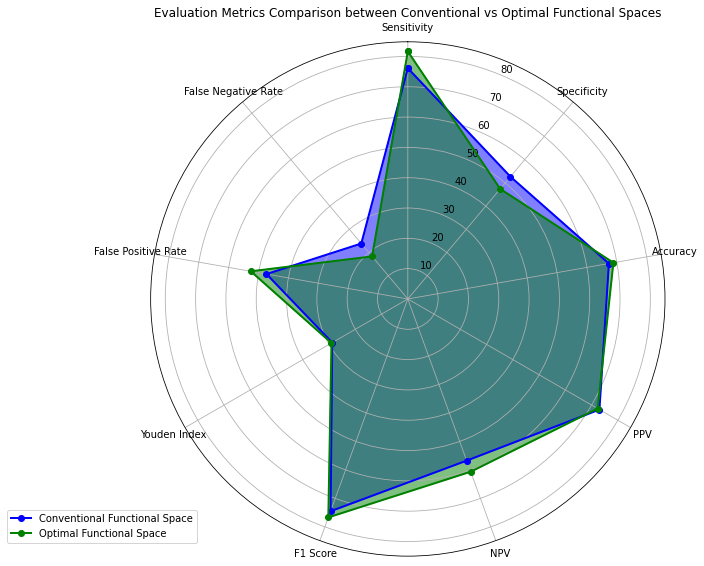

In [14]:
plot_radar_chart(eval_metrics_fs_conv_LW, eval_metrics_fs_opt_LW, AC = False)

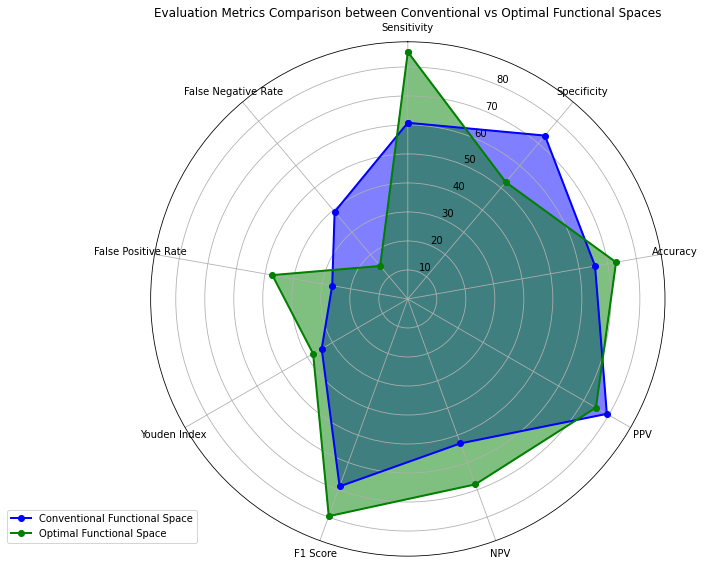

In [15]:
plot_radar_chart(eval_metrics_fs_conv_RW, eval_metrics_fs_opt_RW, AC = False)

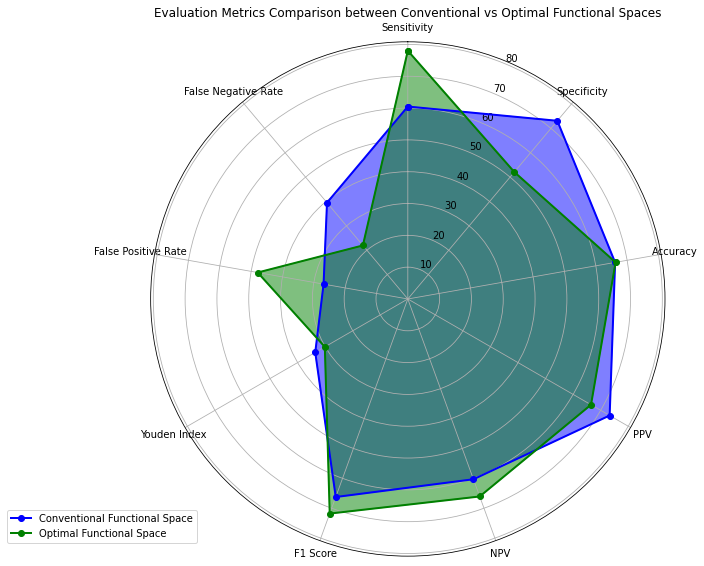

In [16]:
plot_radar_chart(eval_metrics_fs_conv_bil, eval_metrics_fs_opt_bil, AC = False)

In [17]:
# Saving data for this participant 

In [21]:
# Create a structure to save all the metrics 
metrics_dictionary = create_metrics_dictionary(eval_metrics_fs_conv_LW, eval_metrics_fs_conv_RW, eval_metrics_fs_conv_bil, eval_metrics_fs_opt_LW, eval_metrics_fs_conv_RW, eval_metrics_fs_opt_bil)

In [22]:
# Save metrics as csv file: evaluation metrics on unseen data 
save_metrics_dictionary_as_csv(metrics_dictionary, participant_path, AC = False)
# Save optimal AC threhshold for this participant 
save_optimal_threshold(participant_path, optimal_fs_LW, optimal_fs_RW, AC = False)

The metrics dictionary has been saved as ../CreateStudy\H001\evaluation_metrics_GM.csv.
Thresholds saved successfully at: ../CreateStudy\H001\optimal_threshold_GM.csv
